# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [12]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Read in the dms data and list all available experimental conditions**

In [13]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../data/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../data/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [4]:
print(f"Available conditions for fitting are: {list(func_score_data.condition.unique())}")

Available conditions for fitting are: ['Delta-1', 'Delta-3', 'Delta-4', 'Delta-2', 'Omicron_BA1-1', 'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2']


In [14]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "sample" : False, #20000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False,
    "reference_condition" : "Omicron_BA1-2",
    "conditions" : [
        'Delta-1', 'Delta-2', 'Delta-3', 'Delta-4', 
        'Omicron_BA1-1', 'Omicron_BA1-2', 'Omicron_BA1-3', # Bernadeta has warned against BA1 library 1
        'Omicron_BA2-1', 'Omicron_BA2-2'
    ]
}

## Pre-Proccessing

**Query the conditions to be included in a fit**

In [15]:
func_score_data_sub = func_score_data.query(
    f"condition.isin({list(prep_params['conditions'])})"
)
# func_score_data_sub = func_score_data.query(
#     f"condition == 'Delta-3'"
# )
func_score_data_sub

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1


In [16]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data_sub.iterrows(), total=len(func_score_data_sub)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.info()

  0%|          | 0/16 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135096 entries, 0 to 1135095
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   library                      1135096 non-null  object 
 1   pre_sample                   1135096 non-null  object 
 2   post_sample                  1135096 non-null  object 
 3   barcode                      1135096 non-null  object 
 4   func_score                   1135096 non-null  float64
 5   func_score_var               1135096 non-null  float64
 6   pre_count                    1135096 non-null  int64  
 7   post_count                   1135096 non-null  int64  
 8   pre_count_wt                 1135096 non-null  int64  
 9   post_count_wt                1135096 non-null  int64  
 10  pseudocount                  1135096 non-null  float64
 11  n_codon_substitutions        1135096 non-null  int64  
 12  aa_substitutions_sequential  986419 non-nu

**Optionally subset the variants**

In [17]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [19]:
func_score_df.aa_substitutions.fillna("", inplace=True)
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
#     if "-" in row["aa_substitutions"]:
#         gapped_sub_vars.append(idx)
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(stop_wt_vars), set(non_numeric_sites))

func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/1135096 [00:00<?, ?it/s]

**Drop all variants with pre-counts below a threshold.**

In [20]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {prep_params['min_pre_counts']} counts before selection, and were filtered out")

Of 1117330 variants, 118275 had fewer than 100 counts before selection, and were filtered out


In [21]:
func_score_df

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAAATTCATTATGTTC,-0.9244,0.0006,11079,5259,1187006,1069422,0.5,4,R212G N437- A844H L1242-,4,R214G N439- A846H L1244-,23,Delta,1,Delta-1
1,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TAGGATAGTAACTTGA,-0.4382,0.0005,9613,6392,1187006,1069422,0.5,5,N485T T676Y A686G A843R,4,N487T T678Y A688G A845R,23,Delta,1,Delta-1
2,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TCTACAGCGATAAAGA,-0.0208,0.0005,8879,7885,1187006,1069422,0.5,3,R78G D226Y G445D,3,R78G D228Y G447D,23,Delta,1,Delta-1
3,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CACTATTTATTTTGAC,-0.2993,0.0007,7396,5415,1187006,1069422,0.5,2,E778D D1161G,2,E780D D1163G,23,Delta,1,Delta-1
4,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GCATAGCTAATAATCA,-0.7267,0.0009,6813,3709,1187006,1069422,0.5,3,A258V T825I Y1204H,3,A260V T827I Y1206H,23,Delta,1,Delta-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121897,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TGGACGAGAAATCCAG,-0.1622,0.0356,100,139,6478978,10063399,0.5,1,E468Q,1,E471Q,56,Omicron_BA2,2,Omicron_BA2-2
1121898,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTACACAAAACGTGTG,0.5809,0.0296,100,233,6478978,10063399,0.5,1,K1188S,1,K1191S,56,Omicron_BA2,2,Omicron_BA2-2
1121899,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTCATAAAAATTTCAA,1.5701,0.0252,100,463,6478978,10063399,0.5,1,L10I,1,L10I,56,Omicron_BA2,2,Omicron_BA2-2
1121900,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TTCCCTGCAATAATTC,1.3412,0.0260,100,395,6478978,10063399,0.5,3,G72C L365I A1219S,3,G75C L368I A1222S,56,Omicron_BA2,2,Omicron_BA2-2


**Optionally, scale the counts**

In [22]:
if prep_params['scale_counts']:
    func_score_df = multidms.utils.scale_func_score(func_score_df)

In [23]:
func_score_df.columns

Index(['library', 'pre_sample', 'post_sample', 'barcode', 'func_score',
       'func_score_var', 'pre_count', 'post_count', 'pre_count_wt',
       'post_count_wt', 'pseudocount', 'n_codon_substitutions',
       'aa_substitutions_sequential', 'n_aa_substitutions', 'aa_substitutions',
       'pre_count_threshold', 'homolog', 'replicate', 'condition'],
      dtype='object')

In [24]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**Optionally, clip the target functional scores**

In [412]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

In [413]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

In [414]:
func_score_df

,func_score,aa_substitutions,condition
0,-0.1131,D215P D253N H954A N1125H,Omicron_BA.1-2
1,-1.0064,,Omicron_BA.1-2
2,-0.0414,,Omicron_BA.1-2
3,-1.1616,N99D,Omicron_BA.1-2
4,-0.4821,Y449H,Omicron_BA.1-2
...,...,...,...
604975,-0.1622,E471Q,Omicron_BA.2-2
604976,0.5809,K1191S,Omicron_BA.2-2
604977,1.5701,L10I,Omicron_BA.2-2
604978,1.3412,G75C L368I A1222S,Omicron_BA.2-2


In [18]:
import polyclonal
from functools import partial

In [19]:
rep1_name_map = {
    "Delta-3":"Delta", 
    "Omicron_BA.1-2":"Omicron_BA1", 
    "Omicron_BA.2-1":"Omicron_BA2"
}
fs_rep1 = func_score_df.query("condition in @rep1_name_map.keys()").copy()
fs_rep1["condition"] = fs_rep1.condition.replace(rep1_name_map)

rep2_name_map = {
    "Delta-4":"Delta", 
    "Omicron_BA.1-3":"Omicron_BA1", 
    "Omicron_BA.2-2":"Omicron_BA2"
}
fs_rep2 = func_score_df.query("condition in @rep2_name_map.keys()").copy()
fs_rep2["condition"] = fs_rep2.condition.replace(rep2_name_map)

## `MultiDmsData`

**After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.**

In [20]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [51]:
datasets = pd.DataFrame()
for rep in [fs_rep1, fs_rep2]:
    start = time.time()
    data = multidms.MultiDmsData(
        rep,
        alphabet= multidms.AAS_WITHSTOP_WITHGAP,
        condition_colors = sns.color_palette("Paired"),
        reference="Omicron_BA1",
        assert_site_integrity = False,
        verbose=True
    )
    end = time.time()
    print(f"Finished, time: {round(end-start)}")
    data_row = pd.Series(prep_params).to_frame().T
    data_row['data'] = data
    datasets = pd.concat([datasets, data_row], ignore_index=True)
    
datasets

inferring site map for Delta
inferring site map for Omicron_BA1
inferring site map for Omicron_BA2
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 43
inferring site map for Delta
inferring site map for Omicron_BA1
inferring site map for Omicron_BA2
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 41


,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"[Delta-3, Delta-4, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f3fec...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"[Delta-3, Delta-4, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f3f0c...


**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

## `MultiDmsModel`

**To fit a mopdel, we first choose a dataset(s) we would like to fit**

In [52]:
# un-comment to re-initialize results
# models = defaultdict(list)

In [94]:
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,reference_condition,conditions,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"[Delta-3, Delta-4, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f3fec...
1,False,100,0.1,False,"(-3.5, 2.5)",False,Omicron_BA.1-2,"[Delta-3, Delta-4, Omicron_BA.1-2, Omicron_BA....",<multidms.data.MultiDmsData object at 0x7f3f0c...


In [53]:
# models

defaultdict(list,
            {'model': [<multidms.model.MultiDmsModel at 0x7f3f08576410>,
             'dataset': [0, 1]})

**Next, we iterate through datasets and model definitions of interest and (1) initialize a model object with the respective dataset (2) fit that data to a model with some given hyperparameters and (3) save the models in a dataframe for comparison and plotting.**

In [316]:
import multidms.model as model
for dataset in datasets.index:
    for ge_func in [model.perceptron_global_epistasis]:
        for output_act in [model.softplus_activation]:
            
            imodel = multidms.MultiDmsModel(
                    datasets.loc[dataset, 'data'],
                    epistatic_model=ge_func,
                    output_activation=output_act,
                    n_percep_units=10
            )
            
            start = time.time()
            imodel.fit(lasso_shift=2e-5, maxiter=10000, tol=1e-6)
            end = time.time()
            print(f"done. fitting time = {round(end - start)} seconds")
            
            models["model"].append(imodel)
            models["dataset"].append(dataset)
            
models_df = pd.DataFrame(models)
models_df.tail(20)

done. fitting time = 129 seconds
done. fitting time = 126 seconds


,model,dataset
0,<multidms.model.MultiDmsModel object at 0x7f3f...,0
1,<multidms.model.MultiDmsModel object at 0x7f3f...,1
2,<multidms.model.MultiDmsModel object at 0x7f3d...,0
3,<multidms.model.MultiDmsModel object at 0x7f3e...,1
4,<multidms.model.MultiDmsModel object at 0x7f3d...,0
5,<multidms.model.MultiDmsModel object at 0x7f3f...,1
6,<multidms.model.MultiDmsModel object at 0x7f3d...,0
7,<multidms.model.MultiDmsModel object at 0x7f3f...,1
8,<multidms.model.MultiDmsModel object at 0x7f3f...,0
9,<multidms.model.MultiDmsModel object at 0x7f3f...,1


In [420]:
models_df

,model,dataset
0,<multidms.model.MultiDmsModel object at 0x7f3d...,0
1,<multidms.model.MultiDmsModel object at 0x7f3e...,1


### Visualization

**The one mutable attribute of MultiDmsData objects is the condition_colors. We will set a custom color patte to be shared across datasets such that our multiple fit plots are consistant.**

In [317]:
import matplotlib.colors as colors

palette = [
    '#F97306',#, '#FFA500',
    '#BFBFBF',#,'#404040',
    '#9400D3'#, '#EE82EE',
]

conditions = [
    "Delta",# "Delta-3",
    "Omicron_BA1",# "Omicron_BA.1-3",
    "Omicron_BA2"#, "Omicron_BA.2-2"
]
cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}

for row, values in datasets.iterrows():
    values.data.condition_colors = cc

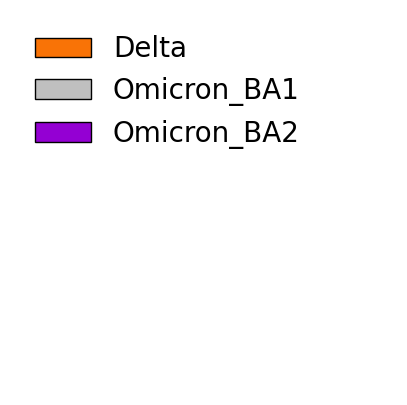

In [428]:
fig,ax = plt.subplots(figsize=[5,5])
ax.axis('off')

legend_elements = [
    patches.Patch(
         facecolor=cc[con], 
         edgecolor="black", 
         label=con
    )
    for con in conditions
]
ax.legend(
        handles=legend_elements, 
        loc="upper left",
        frameon=False,
        fontsize=20
)
plt.show()

In [329]:
moi1 = models_df.loc[0, "model"]
moi2 = models_df.loc[1, "model"]
import multidms.plot

In [394]:
chart = multidms.plot.mut_shift_plot({"rep1":moi1, "rep2":moi2}, include_beta=True)
chart.save("replicates-w-beta.html")


/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


In [331]:
# chart = multidms.plot.mut_shift_plot({"rep1":moi1, "rep2":moi2}, include_beta=False)
# # chart.save("replicates-wo-beta.html")
# chart

In [351]:
df = multidms.plot.mut_shift_plot({"rep1":moi1, "rep2":moi2}, include_beta=True, times_seen_threshold=5)
df = df[["wildtype", "site", "mutant"] + sorted(list(set(df.columns)-set(["wildtype", "site", "mutant"])))]
df_site = df.groupby("site").aggregate(onp.sum)
for condition in ["Delta", "Omicron_BA2"]:
    df_site.loc[:, f"is_{condition}_nis"] = [                                                                     
        True if s in nis1[condition].index else False                                                      
        for s in df_site.index             
    ]

/tmp/ipykernel_19077/4201978614.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_site = df.groupby("site").aggregate(onp.sum)


In [352]:
df

,wildtype,site,mutant,rep1_S_Delta,rep1_S_Omicron_BA2,rep1_β,rep2_S_Delta,rep2_S_Omicron_BA2,rep2_β,value_S_Delta,value_S_Omicron_BA2,value_β
mutation,,,,,,,,,,,,
M1I,M,1,I,0.058993,0.003312,-5.065169,0.033561,0.073079,-5.269749,0.046277,0.038195,-5.167459
F2L,F,2,L,-0.029106,-0.306920,0.180319,-0.008763,0.010135,0.247716,-0.018934,-0.148392,0.214018
V3F,V,3,F,0.032410,0.020886,-0.371107,-0.002374,0.081889,-0.309323,0.015018,0.051388,-0.340215
V3G,V,3,G,-0.125308,0.010756,-0.011046,0.089502,-0.114005,0.088741,-0.017903,-0.051624,0.038848
V3I,V,3,I,0.018647,0.186792,-0.181470,0.058707,0.189030,-0.296346,0.038677,0.187911,-0.238908
...,...,...,...,...,...,...,...,...,...,...,...,...
S1252T,S,1252,T,-0.219116,-0.101389,-0.174831,-0.033191,-0.017636,-0.205568,-0.126154,-0.059512,-0.190200
S1252V,S,1252,V,-0.273857,-0.081906,0.223638,-0.324733,-0.237081,0.295801,-0.299295,-0.159493,0.259720
S1252W,S,1252,W,0.413082,0.087090,0.054516,-0.013452,-0.145620,0.391362,0.199815,-0.029265,0.222939


In [353]:
def sum_abs(x): 
    return sum([abs(t) for t in x if t == t])
def mean_abs(x): 
    return onp.mean([abs(t) for t in x if t == t])
def max_abs(x): 
    return onp.max([abs(t) for t in x if t == t])

In [354]:
nis1 = moi1.data.non_identical_sites
nis2 = moi2.data.non_identical_sites

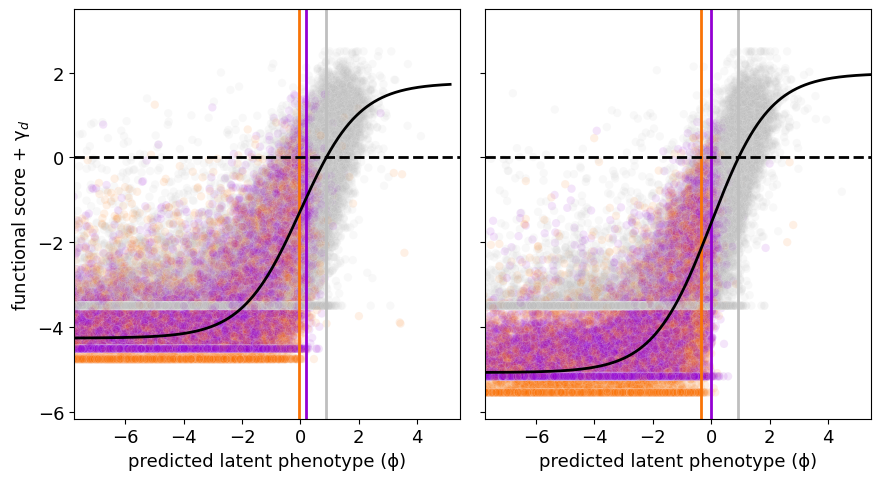

In [396]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,2, figsize=[9,5], sharex=True, sharey=True)
moi1.plot_epistasis(alpha=0.1, ax=ax[0], show=False, legend=False)
moi2.plot_epistasis(alpha=0.1, ax=ax[1], show=False, legend=False)
fig.savefig(f"epistasis-1e.png")
plt.show()

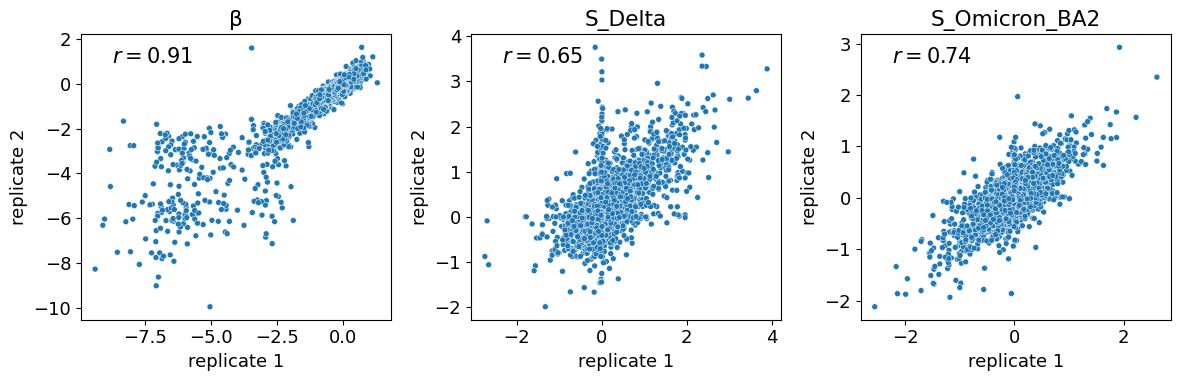

In [398]:
plt.rcParams.update({'font.size': 13})
import math
fig, ax = plt.subplots(1,3,figsize=[12,4])

# i=0
for j, param in enumerate(["β","S_Delta", "S_Omicron_BA2"]):
#     ax = ax[j]
    sns.scatterplot(                                       
        data=df,
        x=f"rep1_{param}",
        y=f"rep2_{param}",                        
        size=2,               
#         color=cc[condition],                                                    
        ax=ax[j],                                                             
        legend=False                       
    )
#     ax[i, j].get_xaxis().set_visible(False)
#     ax[i, j].get_yaxis().set_visible(False)

    x = df[f"rep1_{param}"]
    y = df[f"rep2_{param}"]
    r = pearsonr(x, y)[0]

    ax[j].annotate(
        f"$r = {r:.2f}$", (0.1, 0.9),
        xycoords="axes fraction", fontsize=15, color="black"
    )
    ax[j].set_title(param)
    ax[j].set_xlabel("replicate 1")
    ax[j].set_ylabel("replicate 2")
plt.tight_layout()
fig.savefig(f"rep-corr-mut.png")
plt.show()
    

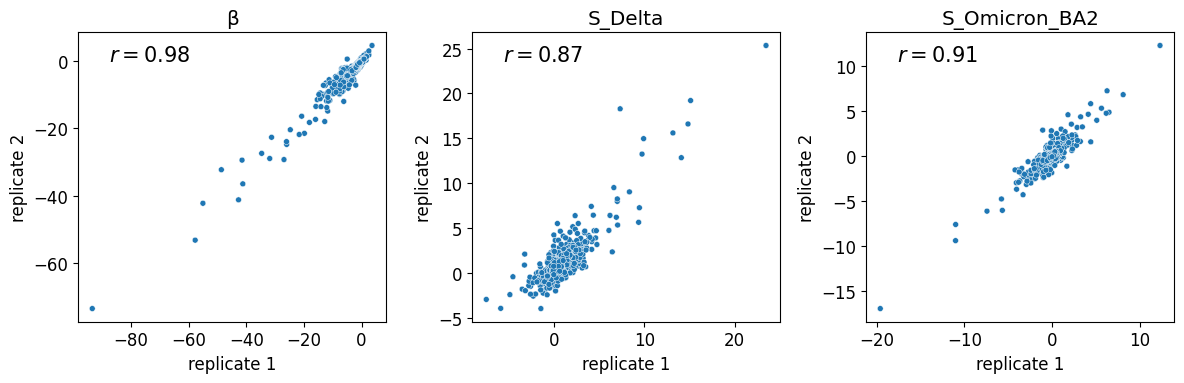

In [399]:
plt.rcParams.update({'font.size': 12})
import math
fig, ax = plt.subplots(1,3,figsize=[12,4])

# i=0
for j, param in enumerate(["β","S_Delta", "S_Omicron_BA2"]):
#     ax = ax[j]
    sns.scatterplot(                                       
        data=df_site,
        x=f"rep1_{param}",
        y=f"rep2_{param}",                        
        size=2,               
#         color=cc[condition],                                                    
        ax=ax[j],                                                             
        legend=False                       
    )
#     ax[i, j].get_xaxis().set_visible(False)
#     ax[i, j].get_yaxis().set_visible(False)

    x = df_site[f"rep1_{param}"]
    y = df_site[f"rep2_{param}"]
    r = pearsonr(x, y)[0]

    ax[j].annotate(
        f"$r = {r:.2f}$", (0.1, 0.9),
        xycoords="axes fraction", fontsize=15, color="black"
    )
    ax[j].set_title(param)
    ax[j].set_xlabel("replicate 1")
    ax[j].set_ylabel("replicate 2")
    
plt.tight_layout()
fig.savefig(f"rep-corr-site.png")

plt.show()
    

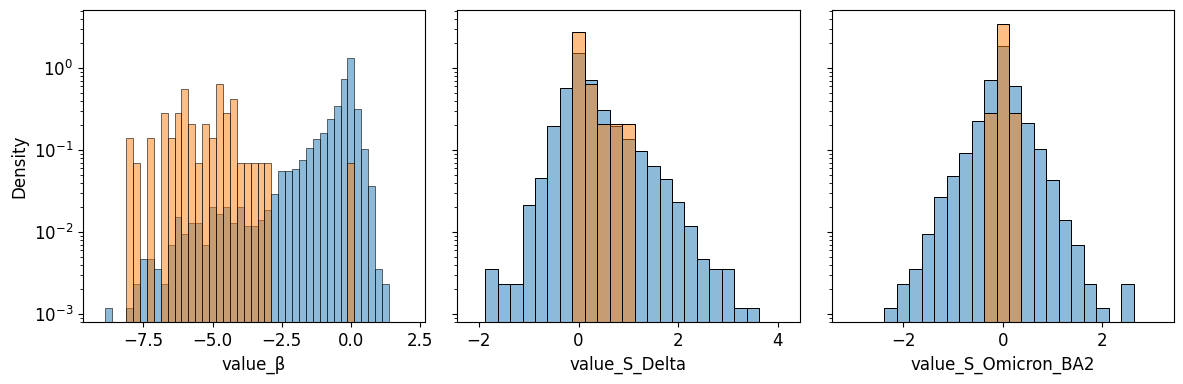

In [369]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1,3,figsize=[12,4], sharey=True)
for j, param in enumerate(["value_β","value_S_Delta", "value_S_Omicron_BA2"]):
#     ax=ax[j]

#     fig, ax = plt.subplots(figsize=[3, 3])
    data = df[df["mutant"] != "*"]
    bin_width = 0.25
    min_val = math.floor(data[param].min()) - 0.25 / 2
    max_val = math.ceil(data[param].max())
    sns.histplot(
        x=param,
        data=data,
        ax=ax[j],
        stat="density",
        label="muts to amino acids",
        binwidth=bin_width,
        binrange=(min_val, max_val),
        alpha=0.5
    )

    # Plot data for mutations leading to stop codons
    data = df[df["mutant"] == "*"]
    if len(data) > 0:
        sns.histplot(
            x=param,
            data=data,
            ax=ax[j],
            stat="density",
            label="muts to stop codons",
            binwidth=bin_width,
            binrange=(min_val, max_val),
            alpha=0.5
        )

    ax[j].set(xlabel=param)
#     ax[i].set(title=group)
    ax[j].set_yscale("log")
#     ax.legend()
plt.tight_layout()

fig.savefig(f"avg-hist-param.png")

# plt.tight_layout()
plt.show()

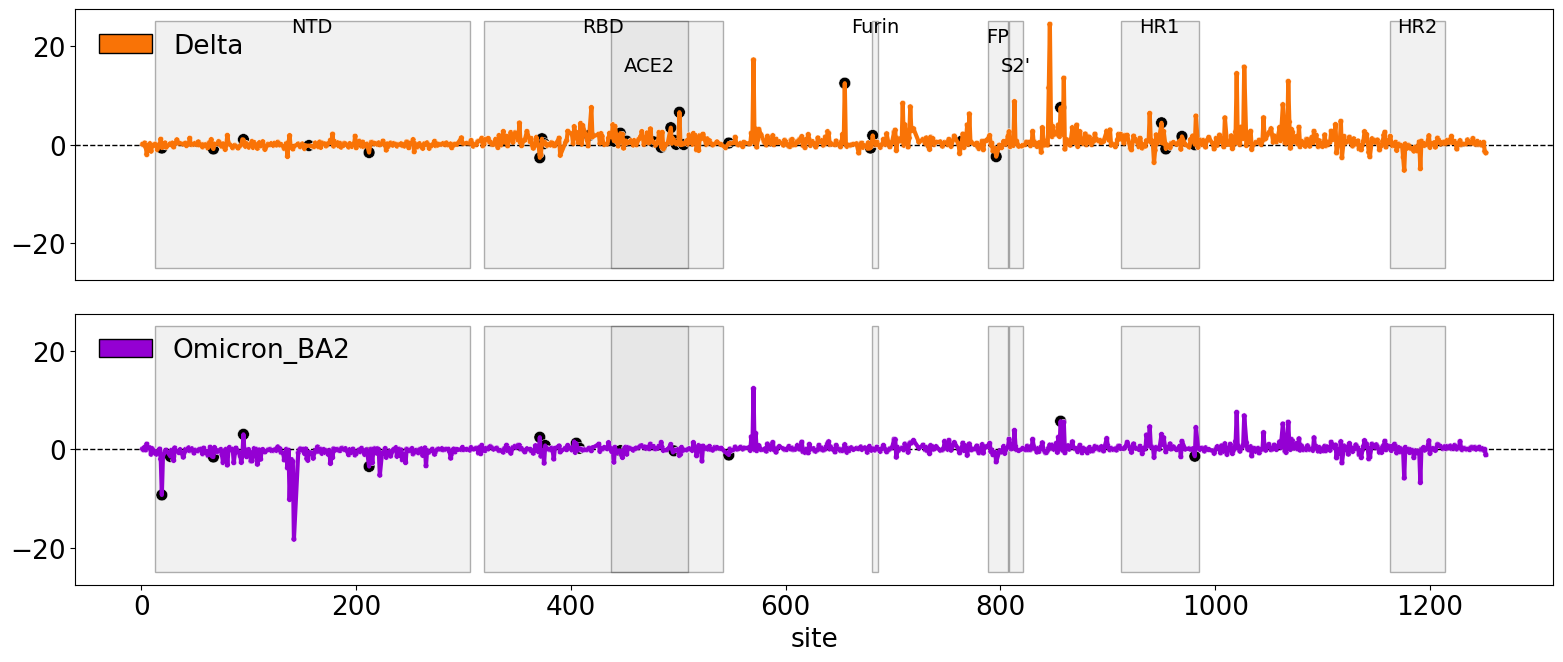

In [386]:
from scipy.stats import pearsonr
def sum_abs(x): 
    return sum([abs(t) for t in x if t == t])
def mean_abs(x): 
    return onp.mean([abs(t) for t in x if t == t])
def max_abs(x): 
    return onp.max([abs(t) for t in x if t == t])

plt.rcParams.update({'font.size': 19})

fig = plt.figure(constrained_layout=True, figsize=(16,7))
axd = fig.subplot_mosaic(
    """
    b
    d
    """,
    empty_sentinel="X",
    gridspec_kw={ 
    }
)

protein_regions = {
    "NTD" :  [13, 305],                                                 
    "RBD" : [319, 541],
    "ACE2" : [437, 508],
    "Furin" : [680, 685],
    "FP" : [788, 806],
    "S2'"  : [808, 820],
    "HR1" : [912, 984],
    "HR2" : [1163, 1213]
}

facet_groups = {
    ("b", "g") : "Delta", #(f"{r}_S_Delta" for r in ["rep1", "rep2", "avg"]),
    ("d", "h") : "Omicron_BA2" #(f"{r}_S_Delta" for r in ["rep1", "rep2", "avg"])
}

for axi, condition in facet_groups.items():

    for pr, data in protein_regions.items():

        start = data[0]
        end = data[1] + 1
        width = end - start
        middle = start + (width//2)

        rect_v = patches.Rectangle(
                (start, -25),
                width=width,
                height=50,
                clip_on=False,
                linewidth=1,
                edgecolor='black',
                facecolor='lightgrey',
                alpha=0.3
        )
        axd[axi[0]].add_patch(rect_v)


    axd[axi[0]].axhline(0, color="k", ls="--", lw=1)


    sns.lineplot(                                       
        data=df_site,                                
        x="site",                     
        y=f"value_S_{condition}",                              
        lw=3,                             
        color=cc[condition],                                                    
        ax=axd[axi[0]],                                                             
        legend=True                       
    )

    color = [                                                                     
        cc[condition]                            
        if not s in nis1[condition].index
        else (0.0, 0.0, 0.0)                                                      
        for s in df_site.index             
    ]                                                                              
    size = [                                
        10 if not s in nis1[condition].index else 15
        for s in df_site.index 
    ] 
    sns.scatterplot(                                       
        data=df_site,                                
        x="site",                     
        y=f"value_S_{condition}",                              
        size=size,                             
        color=color,                                                    
        ax=axd[axi[0]],                                                             
#         legend=False                        
    )


#         for r in ["rep1", "rep2"]:                   

#             sns.lineplot(                                              
#                 data=df_site,                       
#                 x="site",                                                               
#                 y=f"{r}_S_{condition}",
#                 lw=1,
#                 alpha=0.5,
#                 color="grey",                
#                 ax=axd[axi[0]],                                
#                 legend=False                                                    
#             )
    axd[axi[0]].set_ylabel("")

#     sns.scatterplot(                                       
#         data=df_site,
#         x=f"rep1_S_{condition}",
#         y=f"rep2_S_{condition}",                        
#         size=size,               
#         color=cc[condition],                                                    
#         ax=axd[axi[1]],                                                             
#         legend=False                       
#     )
#     axd[axi[1]].get_xaxis().set_visible(False)
#     axd[axi[1]].get_yaxis().set_visible(False)

#     x = df_site[f"rep1_S_{condition}"]
#     y = df_site[f"rep2_S_{condition}"]
#     r = pearsonr(x, y)[0]

#     axd[axi[1]].annotate(
#         f"$r = {r:.2f}$", (0.1, 0.9),
#         xycoords="axes fraction", fontsize=15, color="black"
#     )

for pr, data in protein_regions.items():

    start = data[0]
    end = data[1] + 1
    width = end - start
    middle = start + (width//2)

    anno = f"{pr}"
    ycoord = 24
    if pr in ["ACE2", "S2'"]:
        ycoord = 16
    if pr in ["FP"]:
        ycoord = 22

    axd["b"].text(middle, ycoord, anno, va="center", ha="center", size=14, rotation=0)
    


axd["b"].get_xaxis().set_visible(False)
# axd["b"].legend()
# axd["d"].legend()

# axd["g"].axis('off')

legend_elements = [
    patches.Patch(
         facecolor=cc["Omicron_BA2"], 
         edgecolor="black", 
         label="Omicron_BA2"
    )
]
axd["d"].legend(
        handles=legend_elements, 
        loc="upper left",
        frameon=False
)
legend_elements = [
    patches.Patch(
         facecolor=cc["Delta"], 
         edgecolor="black", 
         label="Delta"
    )
]
axd["b"].legend(
        handles=legend_elements, 
        loc="upper left",
        frameon=False
)


plt.tight_layout()
fig.savefig(f"site-shift.png")

plt.show()
#     fig.savefig("")